### Required imports

In [18]:
import os
import math

import cv2
import librosa
import numpy as np 
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models 
from tensorflow.keras.callbacks import LearningRateScheduler
from vit_keras import vit

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import Isomap

### Directories

In [19]:
directories = (
    '/Users/shrutikmk/Documents/Coding/dog-bird-project/animals/dog',
    '/Users/shrutikmk/Documents/Coding/dog-bird-project/animals/bird'
)

dog_single = '/Users/shrutikmk/Documents/Coding/dog-bird-project/animals/dog/344-3-0-0.wav'
bird_single = '/Users/shrutikmk/Documents/Coding/dog-bird-project/animals/bird/Kus_1.wav'

## Data Processing for Audio Classification

### What does this class do?
This class helps prepare the audio data for training and testing the model. It creates spectrograms (visual representations of audio) and applies data augmentation (making small changes to the data) to improve the model's learning.

### Main Methods:

1. **`make_spectrogram` Method:** Converts an audio file into a visual representation called a spectrogram. It uses the audio data to create an image that the model can understand. If augmentation is enabled, it also applies changes like stretching or shifting to the audio data before creating the spectrogram.

2. **`process_files_in_folder` Method:** Processes all audio files in a given folder. It creates spectrograms for each file, assigns the corresponding label (0 for dog, 1 for bird), and stores them in data and label lists.

3. **`prepare_data` Method:** Prepares the data for training the model. It processes audio files from both dog and bird folders, applies data augmentation, and creates arrays of spectrogram data and their corresponding labels in a format that the model can use.

4. **`augment_audio` Method:** Performs data augmentation on audio data. It can stretch, shift, or add noise to the audio data, which helps the model learn better and become more robust.

In [20]:
class ProcessData:
    def __init__(self, directories):
        self.dog_folder, self.bird_folder = directories

    def make_spectrogram(self, file_name, augment=False):
        y, sr = librosa.load(file_name, sr=None, mono=True, res_type='kaiser_best')
        if augment:
            augment_type = np.random.choice(['time_stretch', 'pitch_shift', 'add_noise'], p=[0.3, 0.3, 0.4])
            y = self.augment_audio(y, sr, augment_type)
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        spec_data = spectrogram[:128, :216]
        if spec_data.shape[1] < 216:
            spec_data = np.pad(spec_data, ((0, 0), (0, 216 - spec_data.shape[1])))
        spec_data = cv2.resize(spec_data, (224, 128))
        return spec_data
    
    def process_files_in_folder(self, folder_name, label, augment=False):
        file_list = os.listdir(folder_name)
        data_list = []
        label_list = []
        for file_name in file_list:
            if file_name.endswith('.wav' or '.flac'):
                spec_data = self.make_spectrogram(os.path.join(folder_name, file_name), augment=augment)
                data_list.append(spec_data)
                label_list.append(label)
        return data_list, label_list
    
    def prepare_data(self):
        data_list = []
        label_list = []
        for file, label in [(self.dog_folder, 0), (self.bird_folder, 1)]:
            data, labels = self.process_files_in_folder(file, label, augment=True)
            data_list += data
            label_list += labels
        data_array = np.array(data_list)
        label_array = tf.keras.utils.to_categorical(label_list, 2) 
        data_array_three = np.repeat(data_array[..., np.newaxis], 3, -1)
        return data_array_three, label_array
    
    def augment_audio(self, y, sr, augment_type):
        if augment_type == 'time_stretch':
            speed_factor = np.random.uniform(0.9, 1.1)
            
            new_length = int(len(y) / speed_factor)
            y_augmented = np.interp(np.linspace(0, len(y), new_length), np.arange(len(y)), y)
        elif augment_type == 'pitch_shift':
            steps = np.random.randint(-2, 3)
            if steps == 0:
                steps = 1
            y_augmented = librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)
        elif augment_type == 'add_noise':
            noise = np.random.randn(len(y))
            y_augmented = y + noise
        else:
            return y
        return y_augmented

## Vision Transformer (VIT) Model

### What does this class do?
This class represents a Vision Transformer (VIT) model for audio classification. The VIT model is a neural network architecture that's designed for image classification tasks. This class adapts the VIT model for audio classification by converting audio spectrograms into "image-like" inputs.

### Main Methods:

1. **`create_vit_model` Method:** Creates a VIT model adapted for audio classification. It determines the patch size and image dimensions suitable for processing audio spectrograms. The VIT model is added on top of the base architecture, followed by a flattening layer and a dense layer for classification.

2. **`compile` Method:** Compiles the VIT model by setting its optimizer, loss function, and evaluation metrics.

3. **`train` Method:** Trains the VIT model using provided training data and labels. It adjusts the learning rate during training using a learning rate schedule.

4. **`evaluate` Method:** Evaluates the VIT model's performance on test data and returns the accuracy.

5. **`lr_schedule` Method:** Defines the learning rate schedule for training. The learning rate starts to decay after a certain number of epochs.

6. **`predict` Method:** Predicts the class label of an audio file using the trained VIT model. It converts the audio data into spectrogram format and processes it through the model. The method also handles the case where the model is uncertain about its prediction.

7. **`getembedding` Method:** Extracts embeddings (feature representations) from the VIT model for given audio data. This can be used for further analysis or visualization of the learned features.

8. **`summary` Method:** Prints a summary of the VIT model's architecture.

In [21]:
class VITModel:
    def __init__(self):
        self.model = self.create_vit_model()

    def create_vit_model(self):
        patch_size = 16
        image_height = 128
        image_width = 216
        
        image_height = int(math.ceil(image_height / patch_size)) * patch_size
        image_width = int(math.ceil(image_width / patch_size)) * patch_size

        vit_model = vit.vit_b32( 
            image_size=(image_height, image_width),
            activation='softmax',
            pretrained=True,
            include_top=False,
            pretrained_top=False,
            classes=2
        )

        model = tf.keras.Sequential([
            vit_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(2, activation='softmax')
        ])

        return model

    def compile(self):
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)  
        self.model.compile(optimizer=optimizer,
                       loss='categorical_crossentropy', 
                       metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    
    def train(self, train_data, train_labels, test_data, test_labels):
        lr_scheduler = LearningRateScheduler(self.lr_schedule)
        history = self.model.fit(train_data, train_labels, 
                                epochs=1, 
                                validation_data=(test_data, test_labels), 
                                callbacks=[lr_scheduler], 
                                shuffle=True)
        return history

    def evaluate(self, test_data, test_labels):
        predictions = self.model.predict(test_data)
        predicted_classes = np.argmax(predictions, axis=1) 
        true_classes = np.argmax(test_labels, axis=1)
        accuracy = np.mean(predicted_classes == true_classes) 
        return accuracy

    def lr_schedule(self, epoch, lr):
        initial_lr = 0.001 
        decay_rate = 0.9  
        decay_step = 1  
        
        if epoch < 5:
            return lr
        else:
            return initial_lr * (decay_rate ** (epoch / decay_step))
    
    def predict(self, audio_file_path):
        processor = ProcessData(directories)
        spec_data = processor.make_spectrogram(audio_file_path)
        spec_data = np.expand_dims(spec_data, axis=0)
        spec_data_three = np.repeat(spec_data[..., np.newaxis], 3, -1)
        
        predictions = self.model.predict(spec_data_three)
        predicted_class = np.argmax(predictions, axis=1)
        label_map = {0: "dog", 1: "bird"}

        if predictions[0][0] < 0.8 and predictions[0][1] < 0.8:
            return "other", predictions[0]
        else:
            return label_map[predicted_class[0]], predictions[0]
        
    def getembedding(self, audio_data):
        vit_model = self.model.layers[0]
        
        intermediate_layer_model = tf.keras.Model(inputs=vit_model.input, outputs=vit_model.output)
            
        embeddings = intermediate_layer_model.predict(audio_data)
        return embeddings

    def summary(self):
        self.model.summary()

## Graph Visualization for Training Loss

### Purpose:
This class helps create a clear visual representation of how training and validation loss change during model training.

### Method: `plot(history)`
- **Purpose:** Displays a plot of training loss and validation loss over epochs.
- **Input:** Training history containing loss values for each epoch.
- **Output:** A graph illustrating loss trends.

### Plot Explanation:
1. A 12x4-inch figure is prepared with `plt.figure(figsize=(12, 4))`.
2. A subplot arrangement of 1 row and 2 columns is set with `plt.subplot(1, 2, 1)` for side-by-side plots.
3. Training loss values are plotted using `plt.plot(history.history['loss'], label='Training Loss')`.
4. Validation loss values are plotted using `plt.plot(history.history['val_loss'], label='Validation Loss')`.
5. A legend is placed in the upper right corner with `plt.legend(loc='upper right')`.
6. The title "Training and Validation Loss" is assigned via `plt.title('Training and Validation Loss')`.
7. X-axis is labeled as "Epoch" with `plt.xlabel('Epoch')`, and y-axis is labeled as "Loss Value" with `plt.ylabel('Loss Value')`.
8. The final command `plt.show()` is used to display the graph.

In [22]:
class Graph:
    def plot(history):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss Value')

        plt.show()

## Model Evaluator for Classification

### Purpose:
This class evaluates the performance of a given model on a dataset and provides insights through various evaluation methods.

### Constructor: `__init__(model, data, labels)`
- **Input:**
  - `model`: Trained model for evaluation.
  - `data`: Input data used for evaluation.
  - `labels`: Corresponding true labels for the input data.
- **Actions:**
  - Computes model predictions for the input data.
  - Adjusts predictions based on a threshold to consider a third class ("other").

### Method: `plot_confusion_matrix()`
- **Purpose:** Displays a graphical representation of the confusion matrix.
- **Input:** None (uses class attributes).
- **Output:** A colored matrix plot showing true and predicted labels.

### Method: `print_classification_report()`
- **Purpose:** Prints a classification report showing various metrics.
- **Input:** None (uses class attributes).
- **Output:** Prints a comprehensive classification report.

### Internal Method: `_adjusted_predictions(predictions)`
- **Purpose:** Adjusts model predictions based on a threshold to include an "other" class.
- **Input:** Array of predicted probabilities.
- **Output:** Adjusted array of predicted classes.

This class simplifies the evaluation of a classification model's performance. It allows visualization of prediction accuracy through a confusion matrix and provides a detailed classification report. Additionally, it adjusts predictions to account for instances where both class probabilities are low, improving model versatility.


In [23]:
class ModelEvaluator:
    def __init__(self, model, data, labels):
        self.model = model
        self.data = data
        self.labels = labels
        self.predictions = self.model.predict(self.data)
        self.predicted_classes = self._adjusted_predictions(self.predictions)       
        self.true_classes = np.argmax(self.labels, axis=1)

    def plot_confusion_matrix(self):
        cm = confusion_matrix(self.true_classes, self.predicted_classes)

        plt.figure(figsize=(10, 7))
        
        plt.matshow(cm, cmap='Blues', fignum=1)
        plt.colorbar()

        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, cm[i, j], ha='center', va='center', color='red')

        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.xticks([0, 1, 2], ['dog', 'bird', 'other'])
        plt.yticks([0, 1, 2], ['dog', 'bird', 'other'])
        plt.show()

    def print_classification_report(self):
        report = classification_report(self.true_classes, self.predicted_classes, target_names=['dog', 'bird', 'other'])
        print(report)
    
    def _adjusted_predictions(self, predictions):
        predicted_classes = np.argmax(predictions, axis=1)
        other_threshold = 0.8
        adjusted_predictions = []

        for prob in predictions:
            if prob[0] < other_threshold and prob[1] < other_threshold:
                adjusted_predictions.append(2)
            else:
                adjusted_predictions.append(np.argmax(prob))

        return np.array(adjusted_predictions)

## KNN-Based Audio Predictor

### Purpose:
This class uses a K-Nearest Neighbors (KNN) algorithm for predicting audio class labels based on pre-computed embeddings from a Vision Transformer (ViT) model.

### Constructor: `__init__(vit_model, reference_data, reference_labels)`
- **Input:**
  - `vit_model`: Trained ViT model for extracting embeddings.
  - `reference_data`: Reference data used to compute embeddings.
  - `reference_labels`: Corresponding labels for the reference data.
- **Actions:**
  - Initializes the KNN classifier with one nearest neighbor.
  - Computes embeddings for the reference data using the ViT model.
  - Fits the KNN model using reference embeddings and labels.

### Method: `predict(audio_path)`
- **Purpose:** Predicts the class label of a new audio sample using KNN and pre-computed embeddings.
- **Input:**
  - `audio_path`: Path to the new audio file for prediction.
- **Output:** Predicted class label ("dog," "bird," or "other").

In [24]:
class KNNBasedPredictor:
    def __init__(self, vit_model, reference_data, reference_labels):
        self.vit_model = vit_model
        self.processor = ProcessData(directories) 
        self.knn = KNeighborsClassifier(n_neighbors=1)

        reference_embeddings = self.vit_model.getembedding(reference_data)
        
        reference_int_labels = np.argmax(reference_labels, axis=1)

        self.knn.fit(reference_embeddings, reference_int_labels)

    def predict(self, audio_path):
        spec_data = self.processor.make_spectrogram(audio_path)
        spec_data = np.expand_dims(spec_data, axis=0)
        spec_data_three = np.repeat(spec_data[..., np.newaxis], 3, -1)

        new_audio_embedding = self.vit_model.getembedding(spec_data_three)
        
        predicted_label = self.knn.predict(new_audio_embedding)
        if predicted_label[0] == 0:
            return "dog"
        elif predicted_label[0] == 1:
            return "bird"
        else:
            return "other"

__Data Processing Initialization:__

processor = ProcessData(directories): Creates an instance of the ProcessData class by passing the directories object as input.


__Preparing Data for Training and Testing:__

data, labels = processor.prepare_data(): Calls the prepare_data() method of the processor to generate preprocessed data and corresponding labels.

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42): Splits the preprocessed data and labels into training and testing sets using a test size of 20%. The random state ensures reproducibility.

In [25]:
processor = ProcessData(directories)
data, labels = processor.prepare_data()
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/librosa/feature/spectral.py:2157: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
Note: Illegal Audio-MPEG-Header 0x66616374 at offset 2266.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x66616374 at offset 12730.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x4c495354 at offset 40390.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Compiles model

In [26]:
vit_model = VITModel()
vit_model.compile()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 4
  warnings.warn(


Train/evaluate model, return accuracy

In [27]:
history = vit_model.train(train_data, train_labels, test_data, test_labels)
accuracy = vit_model.evaluate(test_data, test_labels)
print("Accuracy:", accuracy)

85/85 [==============================] - 103s 1s/step
Accuracy: 0.934902537697683


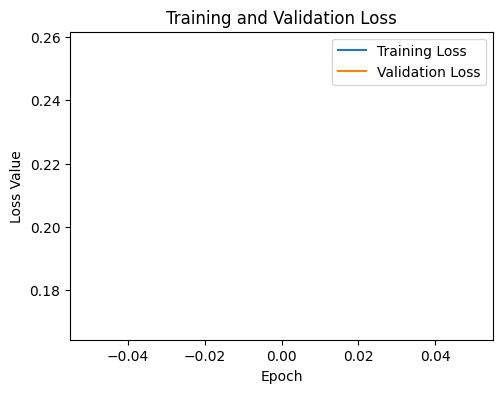

In [28]:
Graph.plot(history)

Creates reference dataset for knn predictor

In [29]:
reference_data = np.vstack([train_data, test_data])
reference_labels = np.vstack([train_labels, test_labels])

In [30]:
knn_predictor = KNNBasedPredictor(vit_model, reference_data, reference_labels)

425/425 [==============================] - 502s 1s/step


In [31]:
print(vit_model.model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87439104  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 2)                 1538      
                                                                 
Total params: 87440642 (333.56 MB)
Trainable params: 87440642 (333.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [32]:
audio_path = bird_single
predicted_class = knn_predictor.predict(audio_path)
print("Predicted Class:", predicted_class)

1/1 [==============================] - 3s 3s/step
Predicted Class: bird


In [34]:
audio_path = dog_single
predicted_class = knn_predictor.predict(audio_path)
print("Predicted Class:", predicted_class)

1/1 [==============================] - 3s 3s/step
Predicted Class: dog


Returns confusion matrix

85/85 [==============================] - 99s 1s/step


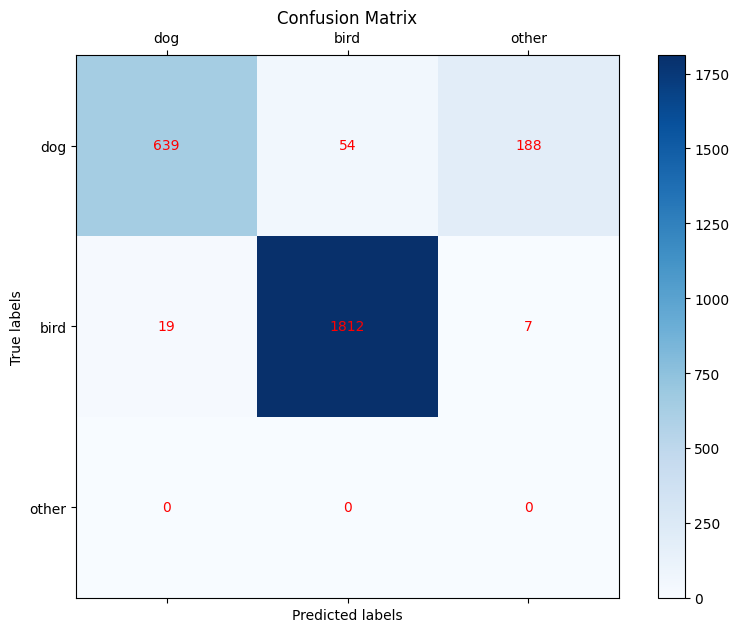

              precision    recall  f1-score   support

         dog       0.97      0.73      0.83       881
        bird       0.97      0.99      0.98      1838
       other       0.00      0.00      0.00         0

    accuracy                           0.90      2719
   macro avg       0.65      0.57      0.60      2719
weighted avg       0.97      0.90      0.93      2719



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [33]:
evaluator = ModelEvaluator(vit_model.model, test_data, test_labels)
evaluator.plot_confusion_matrix()
evaluator.print_classification_report()